## load

In [1]:
import sys
print(sys.version)

3.7.6 (default, Jan  8 2020, 13:42:34) 
[Clang 4.0.1 (tags/RELEASE_401/final)]


In [2]:
#configure for local eicu databse
exec(open("/Users/grovesdixon/gitreps/Insight_fellowship_project/merge/configure_eicu.py").read())
exec(open("my_functions.py").read())

Database: eicu
Username: postgres

Configured for local EICU database.


In [3]:
RAND_SEED=1234
N_JOBS=6
#dat = pd.read_csv("~/projects/Insight/icu_project/my_mimic/readmission_quickCdiff_features.csv")
#dat = pd.read_csv("~/projects/Insight/icu_project/my_mimic/readmission_after_cdiff_features.csv")
#dat = pd.read_csv("~/projects/Insight/icu_project/my_mimic/readmission_cdiff_features.csv")
dat = pd.read_csv("/Users/grovesdixon/projects/Insight/icu_project/my_mimic/any_readmission_features.csv")
pa_column_list = ['diagnosis_icd9', 'procedure_icd9', 'DRUG']
standard_column_list = [i for i in dat.columns if i not in pa_column_list]
sdat = dat.loc[:,standard_column_list]
sdat = sdat.drop_duplicates()
pa_dat = dat.loc[:,['HADM_ID', 'diagnosis_icd9', 'procedure_icd9', 'DRUG']]
print(np.sum(sdat['outcome']))

2436


## handle missing values

In [4]:
sdat.head()

,outcome,SUBJECT_ID,HADM_ID,INSURANCE,RELIGION,MARITAL_STATUS,hospital_duration,ADMISSION_LOCATION,DISCHARGE_LOCATION,GENDER,age,nicu_stays,total_icu_days,total_diagnoses,total_procedure,total_drug
0,0,22,165315,Private,UNOBTAINABLE,MARRIED,1.144444,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,F,64.971282,1.0,1.143750,7,3,NaN
1,0,23,152223,Medicare,CATHOLIC,MARRIED,5.496528,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,M,73.242627,1.0,1.264074,8,7,38.0
40,0,23,124321,Medicare,CATHOLIC,MARRIED,6.768056,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,M,73.242627,1.0,1.186227,10,1,33.0
52,0,24,161859,Private,PROTESTANT QUAKER,SINGLE,2.856944,TRANSFER FROM HOSP/EXTRAM,HOME,M,39.042949,1.0,0.512373,4,6,22.0
60,0,25,129635,Private,UNOBTAINABLE,MARRIED,3.534028,EMERGENCY ROOM ADMIT,HOME,M,58.989281,1.0,3.546574,4,6,35.0


In [5]:
#handle missing values
# print(np.sum(pa_dat.isnull()))
# print(np.sum(sdat.isnull()))
sdat['age'] = sdat['age'].fillna(np.mean(sdat['age'])) #input missing ages with mean
sdat['age'] = sdat['age'].fillna(np.mean(sdat['age'])) #input missing ages with mean
sdat['total_drug'] = sdat['total_drug'].fillna(0) #people that did not recieve drugs
pa_dat = pa_dat.fillna('missing')
# print(np.sum(pa_dat.isnull()))
# print(np.sum(sdat.isnull()))

## add presence absence variables

In [6]:
#function to build boolean column for a column of hospital events
def build_presence_absence_cols(stay_ids, long_df, long_col):
    df = pd.DataFrame(stay_ids)
    levels = long_df[long_col].unique()
    print('making columns for {} levels'.format(len(levels)))
    counter = 0
    for l in levels:
        counter += 1
        if counter % 100 == 0:
            print('level {} of {}'.format(counter, len(levels)))
        new_col = '{}_{}'.format(long_col, l)
        l_ids = long_df.loc[long_df[long_col]==l, 'HADM_ID']
        df[new_col] = df['HADM_ID'].isin(l_ids).astype(int)
    return df

In [7]:
#build boolean columns for diagnoses and add to pdat
stay_ids = sdat['HADM_ID']

#for diagnoses
diag_cols = build_presence_absence_cols(stay_ids, pa_dat, 'diagnosis_icd9')
print(diag_cols.shape)
print('HADM_IDs match = {}'.format(np.sum(diag_cols['HADM_ID']==sdat['HADM_ID'])==sdat.shape[0]))

#for procedures
proc_cols = build_presence_absence_cols(stay_ids, pa_dat, 'procedure_icd9')
print(proc_cols.shape)
print('HADM_IDs match = {}'.format(np.sum(proc_cols['HADM_ID']==sdat['HADM_ID'])==sdat.shape[0]))

#for drugs
drug_cols = build_presence_absence_cols(stay_ids, pa_dat, 'DRUG')
print(drug_cols.shape)
print('HADM_IDs match = {}'.format(np.sum(drug_cols['HADM_ID']==sdat['HADM_ID'])==sdat.shape[0]))

#assemble
cat_list = [
    diag_cols.drop(['HADM_ID'], 1),
    proc_cols.drop(['HADM_ID'], 1),
    drug_cols.drop(['HADM_ID'], 1)]
pa_cols = pd.concat(cat_list, axis=1)
print(pa_cols.shape)
pa_cols.head()
print(sdat.columns)

making columns for 22 levels
(49693, 23)
HADM_IDs match = True
making columns for 3 levels
(49693, 4)
HADM_IDs match = True
making columns for 14 levels
(49693, 15)
HADM_IDs match = True
(49693, 39)
Index(['outcome', 'SUBJECT_ID', 'HADM_ID', 'INSURANCE', 'RELIGION',
       'MARITAL_STATUS', 'hospital_duration', 'ADMISSION_LOCATION',
       'DISCHARGE_LOCATION', 'GENDER', 'age', 'nicu_stays', 'total_icu_days',
       'total_diagnoses', 'total_procedure', 'total_drug'],
      dtype='object')


In [8]:
#onehot encode the pdat columns
to_onehot = ['INSURANCE', 
             'RELIGION', 
             'MARITAL_STATUS',
             'GENDER', 
             'ADMISSION_LOCATION',
             'DISCHARGE_LOCATION']
sdat_cols = pd.get_dummies(sdat, columns = to_onehot, drop_first = True)
for_model = pd.concat([sdat_cols, pa_cols], axis=1)
for_model = for_model.dropna()
for_model

,outcome,SUBJECT_ID,HADM_ID,hospital_duration,age,nicu_stays,total_icu_days,total_diagnoses,total_procedure,total_drug,...,DRUG_Insulin,DRUG_Pantoprazole,DRUG_Spironolactone,DRUG_Lactulose,DRUG_Ketorolac,DRUG_Hydromorphone,DRUG_PredniSONE,DRUG_CefePIME,DRUG_Nephrocaps,DRUG_Labetalol
0,0,22,165315,1.144444,64.971282,1.0,1.143750,7,3,0.0,...,0,0,0,0,0,0,0,0,0,0
1,0,23,152223,5.496528,73.242627,1.0,1.264074,8,7,38.0,...,1,0,0,0,0,0,0,0,0,0
40,0,23,124321,6.768056,73.242627,1.0,1.186227,10,1,33.0,...,1,1,0,0,0,0,0,0,0,0
52,0,24,161859,2.856944,39.042949,1.0,0.512373,4,6,22.0,...,1,1,0,0,0,0,0,0,0,0
60,0,25,129635,3.534028,58.989281,1.0,3.546574,4,6,35.0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1068334,0,98794,190603,4.145833,78.327283,1.0,2.288796,5,2,44.0,...,1,0,0,0,0,0,0,0,0,0
1068338,0,98800,191113,2.742361,19.413381,1.0,0.877778,8,4,33.0,...,1,0,0,0,0,0,0,0,0,0
1068339,0,98805,122631,8.203472,42.559732,1.0,1.952199,17,5,40.0,...,1,1,0,0,0,0,0,0,0,0
1068342,0,98813,170407,41.445833,63.289557,1.0,8.036157,9,4,60.0,...,1,1,0,1,0,0,0,0,0,0


In [9]:
#scale the dataframe
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
need_scaling = [
    'age', 'total_diagnoses','total_procedure', 'total_drug', 'nicu_stays', 'total_icu_days',
]
for_model[need_scaling] = scaler.fit_transform(for_model[need_scaling])
print(np.sum(for_model['outcome']))
for_model.index = for_model['HADM_ID']
for_model.head()

2267


,outcome,SUBJECT_ID,HADM_ID,hospital_duration,age,nicu_stays,total_icu_days,total_diagnoses,total_procedure,total_drug,...,DRUG_Insulin,DRUG_Pantoprazole,DRUG_Spironolactone,DRUG_Lactulose,DRUG_Ketorolac,DRUG_Hydromorphone,DRUG_PredniSONE,DRUG_CefePIME,DRUG_Nephrocaps,DRUG_Labetalol
HADM_ID,,,,,,,,,,,,,,,,,,,,,
165315,0,22,165315,1.144444,0.643391,0.0,0.004386,0.157895,0.058824,0.000000,...,0,0,0,0,0,0,0,0,0,0
152223,0,23,152223,5.496528,0.756713,0.0,0.004847,0.184211,0.176471,0.231707,...,1,0,0,0,0,0,0,0,0,0
124321,0,23,124321,6.768056,0.756713,0.0,0.004549,0.236842,0.000000,0.201220,...,1,1,0,0,0,0,0,0,0,0
161859,0,24,161859,2.856944,0.288156,0.0,0.001964,0.078947,0.147059,0.134146,...,1,1,0,0,0,0,0,0,0,0
129635,0,25,129635,3.534028,0.561433,0.0,0.013602,0.078947,0.147059,0.213415,...,0,1,0,0,0,0,0,0,0,0


## set aside basic and presence absense

In [10]:
for_model.head()
basic = for_model.loc[:,sdat_cols.columns]

## Run basic

In [11]:
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
y = basic['outcome']
X = basic.drop([
    'outcome',
    'SUBJECT_ID',
    'HADM_ID'], 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=321)

In [12]:
# #logistic regression
# from sklearn.linear_model import LogisticRegression
# log_reg = LogisticRegression(max_iter=1000)

# #train
# log_reg.fit(X_train, y_train)

In [13]:
# #performance on the training set
# exec(open("my_functions.py").read())
# probs_train = log_reg.predict_proba(X_train)
# scores_train = probs_train[:, 1]
# train_perf = get_model_performance('logistic regression training set', X_train, scores_train, y_train, pos_label=1)

In [14]:
# #performance on the test set
# probs_test = log_reg.predict_proba(X_test)
# scores_test = probs_test[:, 1]
# test_perf = get_model_performance('logistic regression test set', X_test, scores_test, y_test, pos_label=1)

In [15]:
#------- OPTIMIZE RF

# #use RandomizedSearchCV() to optimized Random forest hyperparameters
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import RandomizedSearchCV
# rf_clf = RandomForestClassifier()

# #choose parameter grid values
# max_depth = [10, 50, 100, 150]
# min_samples_split = [3, 5, 10]
# min_samples_leaf = [1, 2, 3, 4]

# #make grid dict
# random_grid = {'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf}


# # ### run random search
# rf_search = RandomizedSearchCV(estimator = rf_clf,
#                                param_distributions = random_grid,
#                                n_iter = 100,
#                                scoring = 'recall',
#                                cv = 5,
#                                verbose=2,
#                                random_state=RAND_SEED,
#                                n_jobs = N_JOBS)
# rf_search.fit(X_train, y_train)
# best_params = rf_search.best_params_
# print(rf_search.best_params_)


# #or just select the best parameters if already run
# best_params = {'min_samples_split': 10,
#   'min_samples_leaf': 5,
#   'max_features': 'sqrt',
#   'max_depth': 100,
#   'bootstrap': True}

# print('Best parameters:')
# print(best_params)



In [16]:
best_params={'min_samples_split': 3, 'min_samples_leaf': 1, 'max_depth': 150}

In [17]:
#set up optimized rf model based on from best_params above
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
print(best_params)
rf_opt_basic = RandomForestClassifier(n_jobs=N_JOBS,
                                min_samples_split = best_params['min_samples_split'],
                                min_samples_leaf = best_params['min_samples_leaf'],
                                max_depth = best_params['max_depth'],
                                bootstrap = True,
                               random_state=RAND_SEED)

#train
rf_opt_basic.fit(X_train, y_train)

{'min_samples_split': 3, 'min_samples_leaf': 1, 'max_depth': 150}


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=150, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=6,
                       oob_score=False, random_state=1234, verbose=0,
                       warm_start=False)

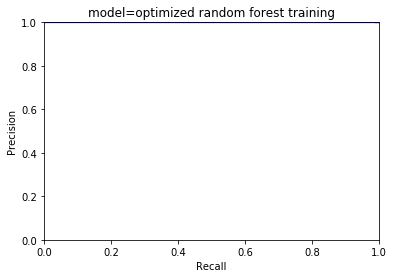

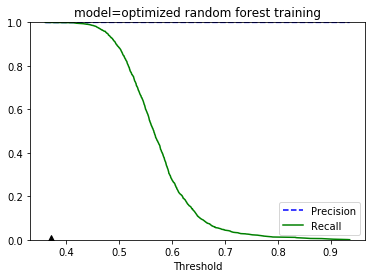

Confusion matrix for threshold = 0.37:
[[37136     1]
 [    2  1787]]
Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     37137
           1       1.00      1.00      1.00      1789

    accuracy                           1.00     38926
   macro avg       1.00      1.00      1.00     38926
weighted avg       1.00      1.00      1.00     38926



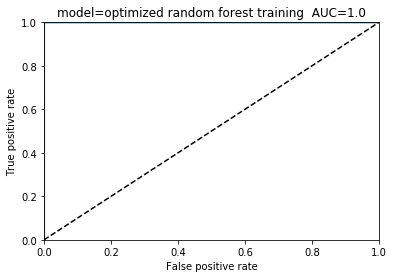

In [18]:
#optimized model performance on training set
scores_opt = rf_opt_basic.predict_proba(X_train)[:, 1]
opt_perf = get_model_performance('optimized random forest training', X_train, scores_opt, y_train, pos_label=1)

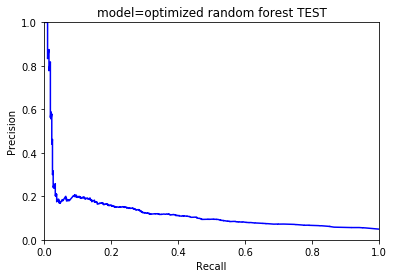

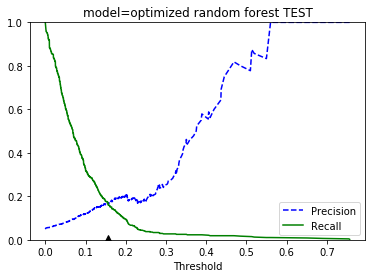

Confusion matrix for threshold = 0.16:
[[8859  395]
 [ 398   80]]
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      9254
           1       0.17      0.17      0.17       478

    accuracy                           0.92      9732
   macro avg       0.56      0.56      0.56      9732
weighted avg       0.92      0.92      0.92      9732



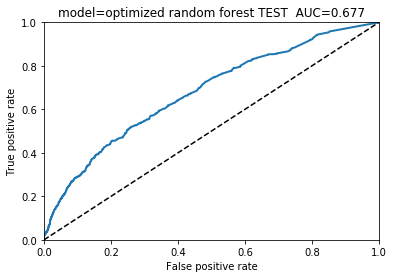

Confusion matrix for threshold = 0.07:
[[7291 1963]
 [ 260  218]]
Classification report:
              precision    recall  f1-score   support

           0       0.97      0.79      0.87      9254
           1       0.10      0.46      0.16       478

    accuracy                           0.77      9732
   macro avg       0.53      0.62      0.52      9732
weighted avg       0.92      0.77      0.83      9732



In [19]:
#predict for test set
test_scores = rf_opt_basic.predict_proba(X_test)[:, 1]
test_perf = get_model_performance('optimized random forest TEST', X_test, test_scores, y_test, pos_label=1)


threshold = 0.075
opt_pred = (test_scores > threshold).astype('int')
y_num = (y_test==1).astype('int')
print('Confusion matrix for threshold = {}:'.format(round(threshold, 2)))
cm = confusion_matrix(y_num, opt_pred)
print(cm)
print('Classification report:')
print(classification_report(y_num, opt_pred))

## run full set

In [20]:
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
y = for_model['outcome']
X = for_model.drop([
    'outcome',
    'SUBJECT_ID',
    'HADM_ID'], 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=RAND_SEED, stratify = y)

### optimaize the RF hyperparameters

In [21]:
#------- OPTIMIZE RF

# #use RandomizedSearchCV() to optimized Random forest hyperparameters
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import RandomizedSearchCV
# rf_clf = RandomForestClassifier()

# #choose parameter grid values
# max_depth = [5, 10, 50, 100, 150]
# min_samples_split = [1, 3, 5, 10]
# min_samples_leaf = [1, 2, 3, 4]

# #make grid dict
# random_grid = {'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf}


# # ### run random search
# rf_search = RandomizedSearchCV(estimator = rf_clf,
#                                param_distributions = random_grid,
#                                n_iter = 100,
#                                scoring = 'recall',
#                                cv = 5,
#                                verbose=2,
#                                random_state=RAND_SEED,
#                                n_jobs = N_JOBS)
# rf_search.fit(X_train, y_train)
# best_params = rf_search.best_params_
# print(rf_search.best_params_)



In [22]:
best_params = {'min_samples_split': 3, 'min_samples_leaf': 1, 'max_depth': 50}

In [23]:
#set up optimized rf model based on from best_params above
rf_opt = RandomForestClassifier(n_jobs=N_JOBS,
                                min_samples_split = best_params['min_samples_split'],
                                min_samples_leaf = best_params['min_samples_leaf'],
                                max_depth = best_params['max_depth'],
                                bootstrap = True,
                               random_state=RAND_SEED)

#train
rf_opt.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=50, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=6,
                       oob_score=False, random_state=1234, verbose=0,
                       warm_start=False)

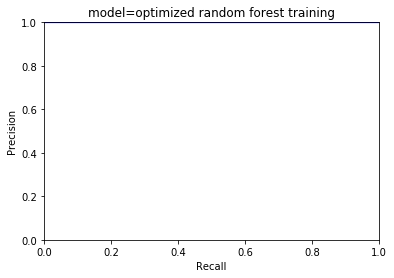

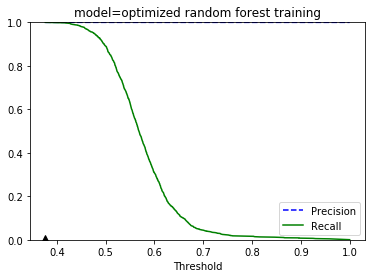

Confusion matrix for threshold = 0.38:
[[37112     0]
 [    1  1813]]
Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     37112
           1       1.00      1.00      1.00      1814

    accuracy                           1.00     38926
   macro avg       1.00      1.00      1.00     38926
weighted avg       1.00      1.00      1.00     38926



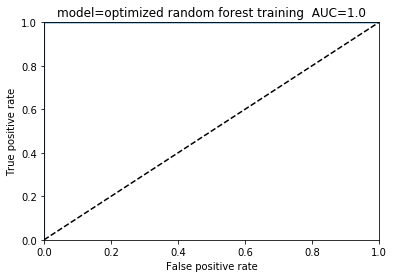

In [24]:
#optimized model performance on training set
probs_opt_t = rf_opt.predict_proba(X_train)
scores_opt_t = probs_opt_t[:, 1]
opt_perf_t = get_model_performance('optimized random forest training', X_train, scores_opt_t, y_train, pos_label=1)

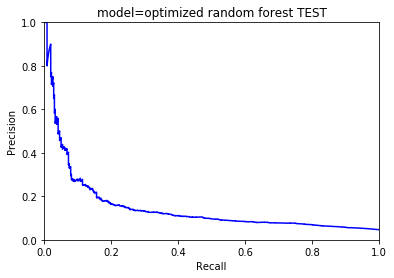

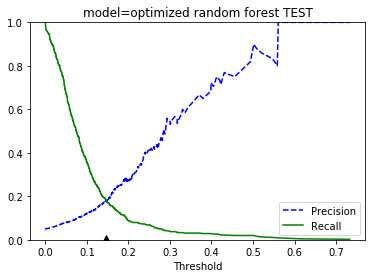

Confusion matrix for threshold = 0.15:
[[8910  369]
 [ 373   80]]
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      9279
           1       0.18      0.18      0.18       453

    accuracy                           0.92      9732
   macro avg       0.57      0.57      0.57      9732
weighted avg       0.92      0.92      0.92      9732



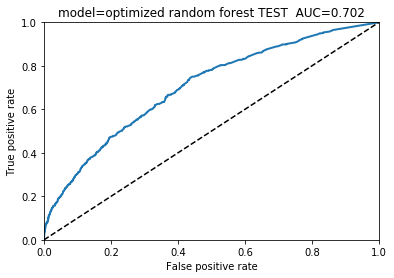

Confusion matrix for threshold = 0.06:
[[6410 2869]
 [ 186  267]]
Classification report:
              precision    recall  f1-score   support

           0       0.97      0.69      0.81      9279
           1       0.09      0.59      0.15       453

    accuracy                           0.69      9732
   macro avg       0.53      0.64      0.48      9732
weighted avg       0.93      0.69      0.78      9732



In [25]:
#predict for test set
test_probs = rf_opt.predict_proba(X_test)
test_scores = test_probs[:, 1]
test_perf = get_model_performance('optimized random forest TEST', X_test, test_scores, y_test, pos_label=1)


threshold = 0.06
opt_pred = (test_scores > threshold).astype('int')
y_num = (y_test==1).astype('int')
print('Confusion matrix for threshold = {}:'.format(round(threshold, 2)))
cm = confusion_matrix(y_num, opt_pred)
print(cm)
print('Classification report:')
print(classification_report(y_num, opt_pred))

# Add NLP data

In [27]:
nlp_dat = pd.read_csv('/Users/grovesdixon/projects/Insight/icu_project/my_mimic/selected_nlp_data.csv')
rn_dict = {'hadm_id':'HADM_ID'}
nlp_dat.rename(columns = rn_dict,inplace=True)
nlp_dat.index = nlp_dat['HADM_ID']
nlp_dat = nlp_dat.drop('HADM_ID', 1)
'outcome' in nlp_dat.columns

False

### merge with structured data

In [28]:
for_merge = for_model.drop('HADM_ID', 1)
with_nlp = pd.merge(nlp_dat, for_merge, how = 'inner', on = 'HADM_ID')
print(nlp_dat.shape)
print(for_model.shape)
print(with_nlp.shape)


(52704, 225)
(48658, 102)
(43408, 326)


In [71]:
with_nlp.to_csv('/Users/grovesdixon/projects/Insight/icu_project/my_mimic/with_nlp.csv')

### prepare for modeling

In [72]:
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
y = with_nlp['outcome']
X = with_nlp.drop(['outcome',
    'SUBJECT_ID'], 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=456, stratify = y)

## logistic with NLP

In [ ]:
# logistic regression
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(max_iter=1000)

#train
log_reg.fit(X_train, y_train)

In [ ]:
#performance on the training set
exec(open("my_functions.py").read())
probs_train = log_reg.predict_proba(X_train)
scores_train = probs_train[:, 1]
train_perf = get_model_performance('logistic regression training set', X_train, scores_train, y_train, pos_label=1)

In [ ]:
#performance on the test set
probs_test = log_reg.predict_proba(X_test)
scores_test = probs_test[:, 1]
test_perf = get_model_performance('logistic regression test set', X_test, scores_test, y_test, pos_label=1)

### optimize random forest for data with NLP

In [66]:
#------- OPTIMIZE RF

# #use RandomizedSearchCV() to optimized Random forest hyperparameters
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import RandomizedSearchCV
# rf_clf = RandomForestClassifier()

# #choose parameter grid values
# max_depth = [5, 10, 50, 100, 150]
# min_samples_split = [1, 3, 5, 10]
# min_samples_leaf = [1, 2, 3, 4]

# #make grid dict
# random_grid = {'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf}


# # ### run random search
# rf_search = RandomizedSearchCV(estimator = rf_clf,
#                                param_distributions = random_grid,
#                                n_iter = 100,
#                                scoring = 'recall',
#                                cv = 5,
#                                verbose=2,
#                                random_state=RAND_SEED,
#                                n_jobs = 1)
# rf_search.fit(X_train, y_train)
# best_params = rf_search.best_params_
# print(rf_search.best_params_)


### or just enter them

In [67]:
best_params = {'min_samples_split': 5, 'min_samples_leaf': 5, 'max_depth': 50}

In [68]:
#set up optimized rf model based on from best_params above
rf_opt = RandomForestClassifier(n_jobs=4,
                                min_samples_split = best_params['min_samples_split'],
                                min_samples_leaf = best_params['min_samples_leaf'],
                                max_depth = best_params['max_depth'],
                                bootstrap = True,
                               random_state=RAND_SEED)

#train
rf_opt.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=50, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=4,
                       oob_score=False, random_state=1234, verbose=0,
                       warm_start=False)

### training performance for optimized RF on data with NLP

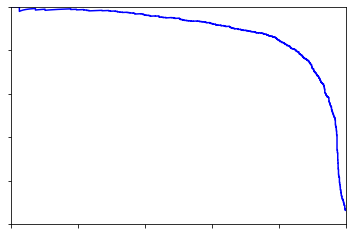

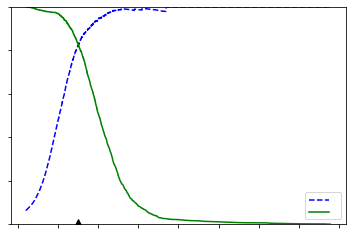

Confusion matrix for threshold = 0.15:
[[36794   318]
 [  319  1495]]
Classification report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     37112
           1       0.82      0.82      0.82      1814

    accuracy                           0.98     38926
   macro avg       0.91      0.91      0.91     38926
weighted avg       0.98      0.98      0.98     38926



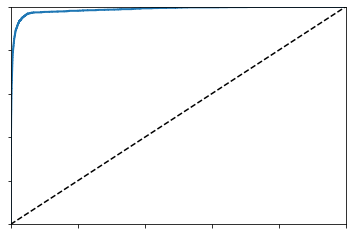

In [69]:
#optimized model performance on training set
probs_opt_t = rf_opt.predict_proba(X_train)
scores_opt_t = probs_opt_t[:, 1]
opt_perf_t = get_model_performance('optimized random forest training', X_train, scores_opt_t, y_train, pos_label=1)

### test performance

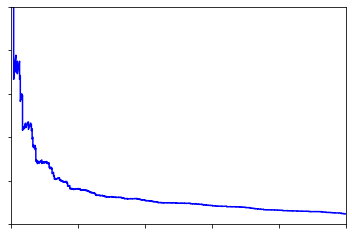

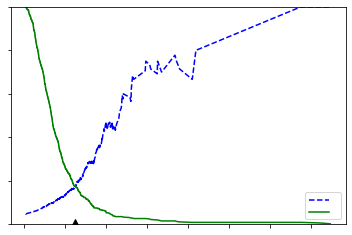

Confusion matrix for threshold = 0.12:
[[8907  372]
 [ 373   80]]
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      9279
           1       0.18      0.18      0.18       453

    accuracy                           0.92      9732
   macro avg       0.57      0.57      0.57      9732
weighted avg       0.92      0.92      0.92      9732



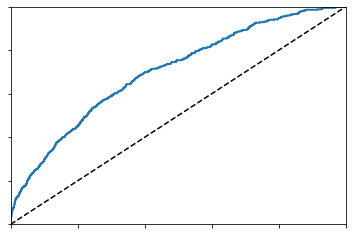

Confusion matrix for threshold = 0.06:
[[6751 2528]
 [ 198  255]]
Classification report:
              precision    recall  f1-score   support

           0       0.97      0.73      0.83      9279
           1       0.09      0.56      0.16       453

    accuracy                           0.72      9732
   macro avg       0.53      0.65      0.49      9732
weighted avg       0.93      0.72      0.80      9732



In [70]:
#predict for test set
test_probs = rf_opt.predict_proba(X_test)
test_scores = test_probs[:, 1]
test_perf = get_model_performance('optimized random forest TEST', X_test, test_scores, y_test, pos_label=1)


threshold = 0.06
opt_pred = (test_scores > threshold).astype('int')
y_num = (y_test==1).astype('int')
print('Confusion matrix for threshold = {}:'.format(round(threshold, 2)))
cm = confusion_matrix(y_num, opt_pred)
print(cm)
print('Classification report:')
print(classification_report(y_num, opt_pred))

# output results for app

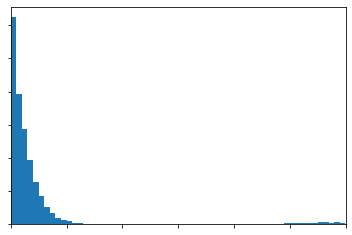

0.0

In [42]:
#gather the results
res = X_train.copy()
res['prob_readmission'] = scores_opt_t
res
plt.hist(res['prob_readmission'], bins=100)
plt.xlim([0, 0.6])
plt.show()
min(res['prob_readmission'])

In [44]:
#pick a high ica stay
high = res.loc[res['prob_readmission'] > 0.8].sort_values('prob_readmission', ascending = False)
high.index = range(len(high.index))
h = high.loc[1,:]
h

#pick a medium
med = res.loc[(res['prob_readmission'] > 0.4),].sort_values('prob_readmission', ascending = True)
med.index = range(len(med.index))
m = med.loc[5,:]

#low
low = res.loc[(res['prob_readmission'] > 0.1),].sort_values('prob_readmission', ascending = True)
low.index = range(len(low.index))
l = low.loc[5,:]
l

#vlow
low = res.loc[(res['prob_readmission'] > 0.005),].sort_values('prob_readmission', ascending = True)
low.index = range(len(low.index))
vl = low.loc[5,:]
vl

example_patients = pd.DataFrame([h,m,l,vl]).drop('prob_readmission', 1)
example_patients.index = ['June Hieghts', 'Jane Middleman', 'Joe Lowe', 'Jess V. Lowe']
example_patients.to_csv('../app/readmission_example_patients.csv', index=True)

In [45]:
res

,hospital_duration,age,nicu_stays,total_icu_days,total_diagnoses,total_procedure,total_drug,INSURANCE_Medicaid,INSURANCE_Medicare,INSURANCE_Private,...,DRUG_Pantoprazole,DRUG_Spironolactone,DRUG_Lactulose,DRUG_Ketorolac,DRUG_Hydromorphone,DRUG_PredniSONE,DRUG_CefePIME,DRUG_Nephrocaps,DRUG_Labetalol,prob_readmission
HADM_ID,,,,,,,,,,,,,,,,,,,,,
132861,6.375000,0.754376,0.0,0.015918,0.315789,0.058824,0.317073,0,1,0,...,0,0,0,0,0,0,0,0,0,0.021667
111378,2.192361,0.845742,0.0,0.003882,0.157895,0.088235,0.000000,0,0,1,...,0,0,0,0,0,0,0,0,0,0.030000
190911,6.577083,0.833566,0.0,0.007079,0.342105,0.029412,0.121951,0,1,0,...,1,0,0,0,0,0,0,0,0,0.030000
155554,7.745139,0.239514,0.0,0.005917,0.184211,0.029412,0.225610,0,0,0,...,1,0,0,0,0,0,0,0,0,0.041667
181409,22.154861,0.592829,0.0,0.074386,0.605263,0.117647,0.359756,1,0,0,...,1,0,0,0,0,1,1,0,0,0.096667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193320,69.895139,0.336595,0.0,0.008341,0.368421,0.294118,0.500000,0,0,1,...,1,0,0,1,1,0,0,0,0,0.021667
177410,5.914583,0.055816,0.0,0.003284,0.131579,0.000000,0.195122,0,0,1,...,0,0,0,0,0,0,0,0,0,0.023000
169728,3.618750,0.781994,0.0,0.007406,0.184211,0.000000,0.128049,0,1,0,...,1,0,0,0,0,0,0,0,0,0.030000


In [46]:
example_patients['GENDER_M']

June Hieghts      0.0
Jane Middleman    0.0
Joe Lowe          1.0
Jess V. Lowe      1.0
Name: GENDER_M, dtype: float64

In [48]:
# save the model to disk
import pickle
filename = '../app/rf_model.sav'
pickle.dump(rf_opt, open(filename, 'wb'))

from joblib import dump, load
dump(rf_opt, '../app/rf_model.joblib') 

['../app/rf_model.joblib']